In [2]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


Import some common utilities from swipeDataUtils.jl (for now, just data import) and import the data using `parseDetailData`

In [2]:
include(joinpath(@__DIR__, "..", "swipeDataUtils.jl"))
dataFile = joinpath(@__DIR__, "dailyHeatmapTestdata.csv")
dataIn = parseDetailData(dataFile)

CSV.File("/Users/jgoldfar/Public/SwiperDataDownloader/HeatMapGenerator/dailyHeatmapTestdata.csv", rows=6749):
Tables.Schema:
 :FIT_ID      Union{Missing, String}  
 :TRACKS      Union{Missing, String}  
 :First_Name  Union{Missing, String}  
 :Last_Name   Union{Missing, String}  
 :Email       Union{Missing, String}  
 :Class       Union{Missing, String}  
 :Context     Union{Missing, String}  
 :Time_In     Union{Missing, DateTime}
 :Time_Out    Union{Missing, DateTime}
 :Total_Time  Union{Missing, String}  

In [3]:
using Dates

In [4]:
struct visitorHistogramData{T1, T2, T3}
    initialTimes::T1
    resolution::T2
    visitors::T3
end
function visitorHistogramData(startTime::Time, resolution::Period, endTime::Time)
    initialTimes = startTime:resolution:endTime
    visitors = zeros(Int, length(initialTimes))
    return visitorHistogramData(initialTimes, resolution, visitors)
end

visitorHistogramData

In [5]:
function reset!(v::visitorHistogramData{T1, T2, T3}) where {T1, T2, T3}
    fill!(v.visitors, 0)
end

reset! (generic function with 1 method)

In [6]:
startTime = Time(8, 0)
endTime = Time(19, 0)
resolution = Minute(15)

15 minutes

In [7]:
dayNames = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
visitorLogVector = [visitorHistogramData(startTime, resolution, endTime) for k in 1:5]

5-element Array{visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}},1}:
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Int64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
foreach(reset!, visitorLogVector)

In [9]:
for row in dataIn
    ti = row.Time_In
    to = row.Time_Out
    if ismissing(ti) || ismissing(to)
        continue
    end
    
    # Assume we checked in & out on the same day of the week
    # which is used to index into the day vector
    dow = Dates.dayofweek(ti)
    
    # Extract time component from time in & time out
    tiTime = Time(ti)
    toTime = Time(to)
    
    # No student is checked in before the center opens
    checkedIn = false

    # Extract component of DaysAndTimes corresponding to the given day
    dataForCheckin = visitorLogVector[dow]
    
    # The time resolution is fixed
    res = dataForCheckin.resolution
    
    # Iterate over all initial time values
    for (k, e) in enumerate(dataForCheckin.initialTimes)
        # If checked in during [e, e + resolution], consider us checked in
        if !checkedIn && (tiTime >= e) && (tiTime <= e + resolution)
            checkedIn = true
        end
        
        # Tabulate everyone checked in during a given time
        if checkedIn
            dataForCheckin.visitors[k] += 1
            # If we check out during this interval, record that here.
            if toTime <= e + resolution
                checkedIn = false
            end
        end
    end
end

In [ ]:
@show visitorLogVector[3].visitors

In [10]:
function rescale(val::visitorHistogramData{T1, T2, T3}, factor = maximum(val.visitors)) where {T1, T2, T3}
    visitorHistogramData(val.initialTimes, val.resolution, val.visitors / factor)
end
function rescale(vals::Vector{visitorHistogramData{T1, T2, T3}}, factor) where {T1, T2, T3}
    [rescale(val, factor) for val in vals]
end
function rescale(vals::Vector{visitorHistogramData{T1, T2, T3}}) where {T1, T2, T3}
    factor = maximum(maximum(val.visitors) for val in vals)
    rescale(vals, factor)
end

rescale (generic function with 4 methods)

In [ ]:
d3rescaled = rescale(visitorLogVector[3])
@show d3rescaled.visitors

In [3]:
import PyPlot
const plt = PyPlot

PyPlot

See the pyplot documentation [here](https://matplotlib.org/gallery/text_labels_and_annotations/date.html) and the PyPlot.jl example [here](https://github.com/gizmaa/Julia_Examples/blob/master/pyplot_customtime.jl)

In [46]:
function createPlotFromDay(
        visitorVals::visitorHistogramData{T1, T2, T3}, 
        dayName::String,
        title_short::Bool = false,
        omit_ylabels::Bool = true) where {T1, T2, T3}
    ax = plt.gca()

    # Times are represented as nanoseconds in Julia.
    timeRaw = visitorVals.initialTimes
    
    # But in Matplotlib, they use whole numbers as day after epoch and
    # decimals for percentage of the day
    times = map(v->(Dates.value(v) // (10^9 * 60 * 60 * 24)) + 1, timeRaw)

    dispFmt = dateformat"HH:MM:SS"

    font1 = Dict("fontname" => "Sans", "style" => "normal")
    majorFormatter = plt.matplotlib[:dates][:DateFormatter]("%H:%M:%S")
    # AutoDateLocator is useful for debugging the tick mark locations
    majorLocator = plt.matplotlib[:dates][:HourLocator](interval=1, byhour=0:23)

    p1 = plt.plot_date(
        times,
        visitorVals.visitors,
        linestyle = "-",
        marker = "None",
        label = "Raw Data"
    )

    # Adjust axis layout
    plt.axis("tight")

    # Set title and labels
    if title_short
        plt.title(dayName)
    else
        timespan = Dates.format(minimum(timeRaw), dispFmt) * " - " * Dates.format(maximum(timeRaw), dispFmt)
        plt.title("Student Traffic on " * dayName * "\n" * timespan)
    end
    
    plt.xlabel("Time", fontdict = font1)
    if !omit_ylabels
        plt.ylabel("Student Traffic", fontdict = font1)
    end

    # Turn on grid
    plt.grid("on")

    # Customize x-axis formatting
    ax[:xaxis][:set_major_formatter](majorFormatter)
    ax[:xaxis][:set_major_locator](majorLocator)
    p1, ax
end

createPlotFromDay (generic function with 7 methods)

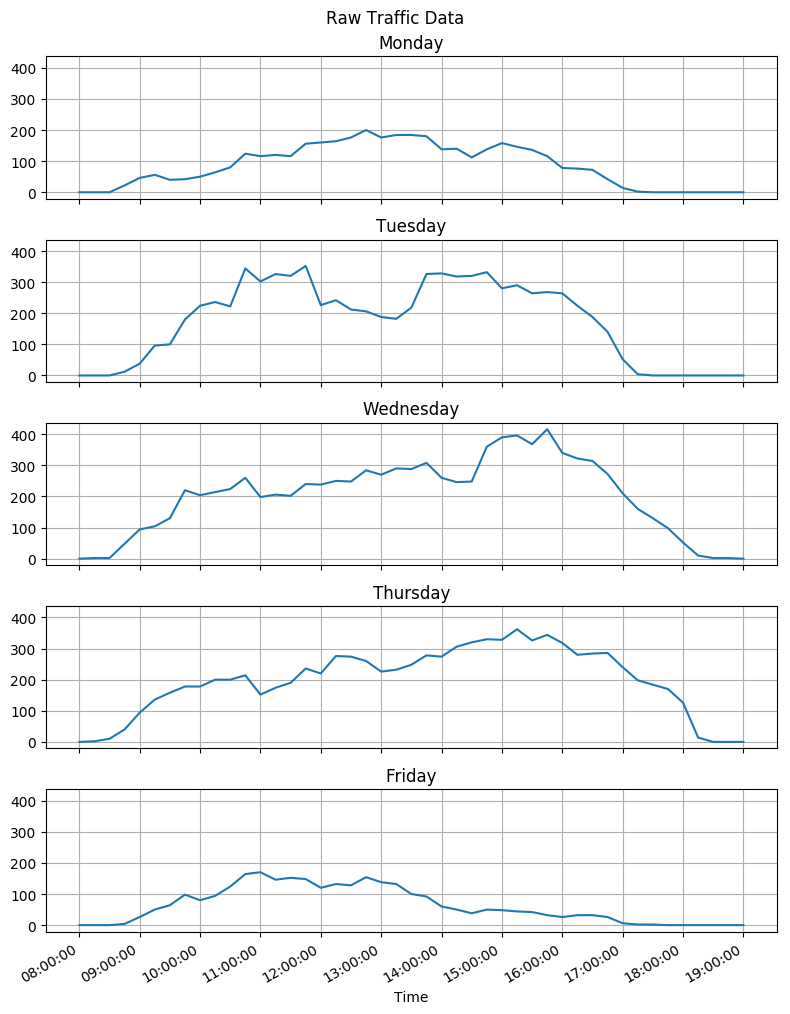

PyObject Text(0.5, 1.01, 'Raw Traffic Data')

In [52]:
# Figure with Raw Data
rawFigure = plt.figure("Raw Data", figsize = (8, 10))

plt.subplot(510 + 1)
p, ax = createPlotFromDay(visitorLogVector[1], dayNames[1], true, true)

for i in 2:5
    plt.subplot(510 + i, sharex = ax, sharey = ax)
    global p, ax = createPlotFromDay(visitorLogVector[i], dayNames[i], true, true)
end

# Adjust vertical spacing in subplot
plt.subplots_adjust(hspace=0.1)

# Modify x-axis formatting
rawFigure[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")

# Update layout
PyPlot.tight_layout()

# Update the figure
rawFigure[:canvas][:draw]()
rawFigure[:suptitle]("Raw Traffic Data", y=1.01, x=0.5)

In [48]:
visitorLogVectorScaled = rescale(visitorLogVector)
# Check:
# length(DaysAndTimesScaled[3].visitors)

5-element Array{visitorHistogramData{StepRange{Time,Minute},Minute,Array{Float64,1}},1}:
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Float64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0.0, 0.0, 0.0, 0.0528846, 0.110577, 0.134615, 0.0961538, 0.100962, 0.120192, 0.153846  …  0.100962, 0.0336538, 0.00480769, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])                                 
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Float64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0.0, 0.0, 0.0, 0.0288462, 0.0913462, 0.230769, 0.240385, 0.432692, 0.538462, 0.567308  …  0.336538, 0.125, 0.00961538, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])                                     
 visitorHistogramData{StepRange{Time,Minute},Minute,Array{Float64,1}}(08:00:00:15 minutes:19:00:00, 15 minutes, [0.0, 0.00480769, 0.00480769, 0.115385, 0.225962, 0.25, 0.3125, 0.528846, 0.490385, 0.514423  …  0.653846, 0.504808, 0.384615, 0.3125, 0.235577, 0.125, 0.0240385, 0.00480769, 0.00480769, 0.

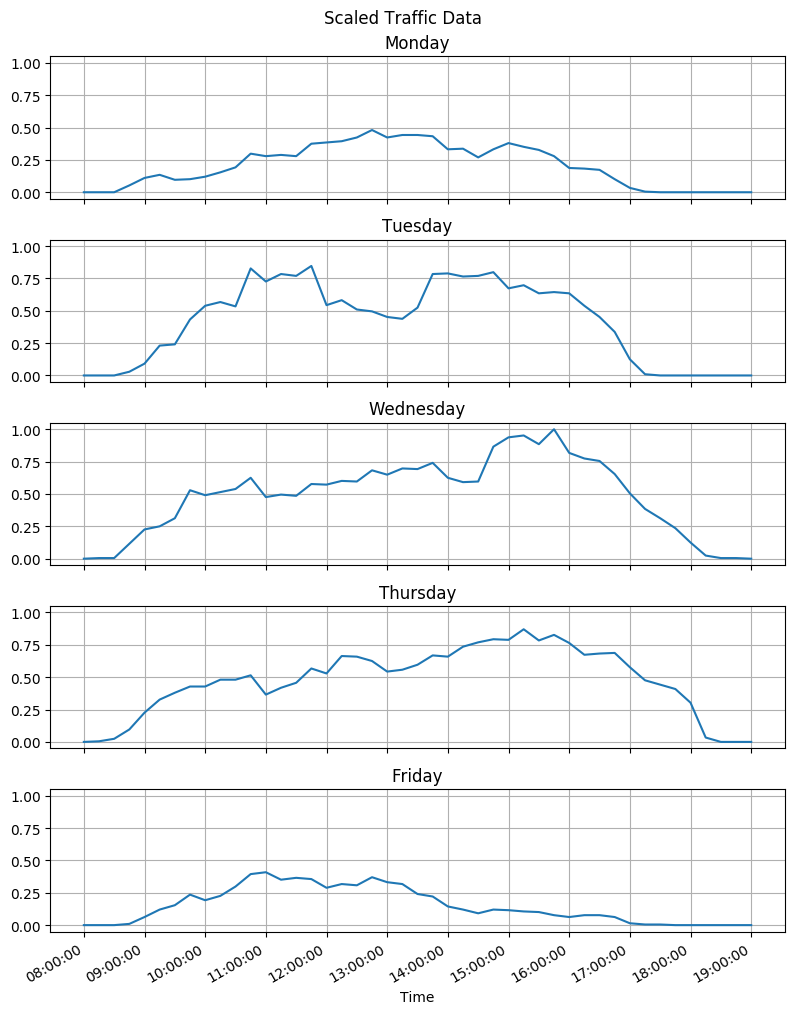

In [51]:
# Figure with week-long normalized data
# Figure with Raw Data
rawFigure = plt.figure("Normalized Data", figsize = (8, 10))

plt.subplot(510 + 1)
p, ax = createPlotFromDay(visitorLogVectorScaled[1], dayNames[1], true, true)

for i in 2:5
    plt.subplot(510 + i, sharex = ax, sharey = ax)
    global p, ax = createPlotFromDay(visitorLogVectorScaled[i], dayNames[i], true, true)
end

# Adjust vertical spacing in subplot
plt.subplots_adjust(hspace=0.1)

# Modify x-axis formatting
rawFigure[:autofmt_xdate](bottom=0.2,rotation=30,ha="right")

# Update layout
PyPlot.tight_layout()

# Update the figure
rawFigure[:suptitle]("Scaled Traffic Data", y=1.01, x=0.5)
rawFigure[:canvas][:draw]()

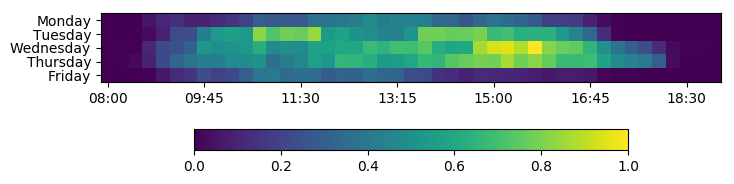

(PyObject <matplotlib.image.AxesImage object at 0x1452bb550>, PyPlot.Figure(PyObject <Figure size 800x400 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1453d0ac8>)

In [116]:
# Heatmap
function createHeatmap(
        dataVals::Vector{visitorHistogramData{T1, T2, T3}},
        nxTicks::Int = 6) where {T1, T2, T3}
    # Use first element of dataVals to set some parameters
    val = first(dataVals)
    
    # Assume visitor vectors are the same size (TODO: Remove assumption)
    nvisitors = length(val.visitors)

    # Interval between x tick values (err on the side of more ticks rather than less)
    xTickInterval = floor(Int, nvisitors / nxTicks)

    # Create matrix of to store heatMap data
    heatData = zeros(5, nvisitors)
    for j in 1:5
        for i in 1:nvisitors
            heatData[j, i] = dataVals[j].visitors[i]
        end
    end

    f, ax = plt.subplots(figsize = (8, 4))

    # Build heatmap
    heatImage = plt.imshow(heatData)

    # Create colorbar
    plt.colorbar(heatImage, ax=ax, shrink=0.7, orientation = "horizontal")

    # Setup x tick labels
    tickLabelFormat = dateformat"HH:MM"
    xTickLabels = map(
        v->Dates.format(v, tickLabelFormat),
        val.initialTimes[1:xTickInterval:end]
        )

    # We want to show all ticks and label them with the respective list entries
    plt.xticks(0:xTickInterval:nvisitors,  xTickLabels)
    plt.yticks(0:4, dayNames)
    heatImage, f, ax
end

heatImage, f, ax = createHeatmap(visitorLogVectorScaled)

In [ ]:
savefig(args...; kws...)